## The pair of dice problem

Copyright 2018 Allen Downey

MIT License: https://opensource.org/licenses/MIT


In [20]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import pandas as pd

import thinkplot
from thinkbayes2 import Pmf, Suite

from fractions import Fraction

### The BayesTable class

Here's the class that represents a Bayesian table.

In [21]:
class BayesTable(pd.DataFrame):
    def __init__(self, hypo, prior=1, **options):
        columns = ['hypo', 'prior', 'likelihood', 'unnorm', 'posterior']
        super().__init__(columns=columns, **options)
        self.hypo = hypo
        self.prior = prior
    
    def mult(self):
        self.unnorm = self.prior * self.likelihood
        
    def norm(self):
        nc = np.sum(self.unnorm)
        self.posterior = self.unnorm / nc
        return nc
    
    def update(self):
        self.mult()
        return self.norm()
    
    def reset(self):
        return BayesTable(self.hypo, self.posterior)

### The pair of dice problem

Suppose I have a box that contains one each of 4-sided, 6-sided, 8-sided, and 12-sided dice.  I choose two dice at random and roll them without letting you see the die or the outcome.  I report that the sum of the dice is 3.

1) What is the posterior probability that I rolled each possible pair of the dice?


2) If I roll the same dice again, what is the probability that the sum of the dice is 11?

**Solution**

I'll start by making a list of possible pairs of dice.

In [22]:
sides = [4, 6, 8, 12]
hypo = []
for die1 in sides:
    for die2 in sides:
        if die2 > die1:
            hypo.append((die1, die2))
            
hypo

[(4, 6), (4, 8), (4, 12), (6, 8), (6, 12), (8, 12)]

Here's a `BayesTable` that represents the hypotheses.

In [23]:
table = BayesTable(hypo)

,hypo,prior,likelihood,unnorm,posterior
0,"(4, 6)",1,NaN,NaN,NaN
1,"(4, 8)",1,NaN,NaN,NaN
2,"(4, 12)",1,NaN,NaN,NaN
3,"(6, 8)",1,NaN,NaN,NaN
4,"(6, 12)",1,NaN,NaN,NaN
5,"(8, 12)",1,NaN,NaN,NaN


Since we didn't specify prior probabilities, the default value is equal priors for all hypotheses.  They don't have to be normalized, because we have to normalize the posteriors anyway.

Now we can specify the likelihoods: if the first die has `n1` sides and the second die has `n2` sides, the probability of getting a sum of 3 is

`2 / n1 / n2`

The factor of `2` is there because there are two ways the sum can be 3, either the first die is `1` and the second is `2`, or the other way around.

So the likelihoods are:

In [24]:
for i, row in table.iterrows():
    n1, n2 = row.hypo
    table.loc[i, 'likelihood'] = 2 / n1 / n2
    
table

,hypo,prior,likelihood,unnorm,posterior
0,"(4, 6)",1,0.0833333,NaN,NaN
1,"(4, 8)",1,0.0625,NaN,NaN
2,"(4, 12)",1,0.0416667,NaN,NaN
3,"(6, 8)",1,0.0416667,NaN,NaN
4,"(6, 12)",1,0.0277778,NaN,NaN
5,"(8, 12)",1,0.0208333,NaN,NaN


Now we can use `update` to compute the posterior probabilities:

In [6]:
table.update()
table

,hypo,prior,likelihood,unnorm,posterior
0,"(4, 6)",1,0.0833333,0.0833333,0.3
1,"(4, 8)",1,0.0625,0.0625,0.225
2,"(4, 12)",1,0.0416667,0.0416667,0.15
3,"(6, 8)",1,0.0416667,0.0416667,0.15
4,"(6, 12)",1,0.0277778,0.0277778,0.1
5,"(8, 12)",1,0.0208333,0.0208333,0.075


### Part two

The second part of the problem asks for the (posterior predictive) probability of getting a total of 11 if we roll the same dice again.

For this, it will be useful to write a more general function that computes the probability of getting a total, `k`, given `n1` and `n2`.

Here's an example with the `4` and `6` sided dice:

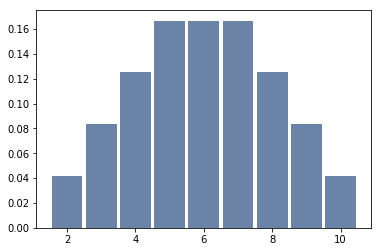

In [7]:
n1, n2 = 4, 6
d1 = Pmf(range(1, n1+1))
d2 = Pmf(range(1, n2+1))
total = d1 + d2
thinkplot.Hist(total)

And here's the general function:

In [8]:
def prob_total(k, n1, n2):
    d1 = Pmf(range(1, n1+1))
    d2 = Pmf(range(1, n2+1))
    total = d1 + d2
    return total[k]

To check the results, I'll compare them to the likelihoods in the previous table:

In [9]:
for i, row in table.iterrows():
    n1, n2 = row.hypo
    p = prob_total(3, n1, n2)
    print(n1, n2, p, p == row.likelihood)

4 6 0.08333333333333333 True
4 8 0.0625 True
4 12 0.041666666666666664 True
6 8 0.041666666666666664 True
6 12 0.027777777777777776 True
8 12 0.020833333333333332 True


Now we can answer the second part of the question using the law of total probability.  The chance of getting `11` on the second roll is the

$\sum_{n1, n2} P(n1, n2 ~|~ D) \cdot P(11 ~|~ n1, n2)$

The first term is the posterior probability, which we can read from the table; the second term is `prob_total(11, n1, n2)`.

Here's how we compute the total probability:

In [10]:
total = 0
for i, row in table.iterrows():
    n1, n2 = row.hypo
    p = prob_total(11, n1, n2)
    total += row.posterior * p 
    
total

0.05364583333333333

This calculation is similar to the first step of the update, so we can also compute it by

1) Creating a new table with the posteriors from `table`.

2) Adding the likelihood of getting a total of `11` on the next roll.

3) Computing the normalizing constant.

In [11]:
table2 = table.reset()
for i, row in table2.iterrows():
    n1, n2 = row.hypo
    table2.loc[i, 'likelihood'] = prob_total(11, n1, n2)
    
table2

,hypo,prior,likelihood,unnorm,posterior
0,"(4, 6)",0.3,0,NaN,NaN
1,"(4, 8)",0.225,0.0625,NaN,NaN
2,"(4, 12)",0.15,0.0833333,NaN,NaN
3,"(6, 8)",0.15,0.0833333,NaN,NaN
4,"(6, 12)",0.1,0.0833333,NaN,NaN
5,"(8, 12)",0.075,0.0833333,NaN,NaN


In [12]:
table2.update()

0.05364583333333333

In [13]:
table2

,hypo,prior,likelihood,unnorm,posterior
0,"(4, 6)",0.3,0,0,0
1,"(4, 8)",0.225,0.0625,0.0140625,0.262136
2,"(4, 12)",0.15,0.0833333,0.0125,0.23301
3,"(6, 8)",0.15,0.0833333,0.0125,0.23301
4,"(6, 12)",0.1,0.0833333,0.00833333,0.15534
5,"(8, 12)",0.075,0.0833333,0.00625,0.116505


### Using a Suite

We can solve this problem more concisely, and more efficiently, using a `Suite`.

First, I'll create `Pmf` object for each die.

In [14]:
dice = {}
for n in sides:
    dice[n] = Pmf(range(1, n+1))

And a `Pmf` object for the sum of each pair of dice.

In [15]:
pairs = {}
for n1 in sides:
    for n2 in sides:
        if n2 > n1:
            pairs[n1, n2] = dice[n1] + dice[n2]

Here's a `Dice` class that implements `Likelihood` by looking up the data, `k`, in the `Pmf` that corresponds to `hypo`: 

In [16]:
class Dice(Suite):
    
    def Likelihood(self, data, hypo):
        """Likelihood of the data given the hypothesis.
        
        data: total of two dice
        hypo: pair of sides
        
        return: probability
        """
        return pairs[hypo][data]

Here's the prior:

In [17]:
suite = Dice(pairs.keys())
suite.Print()

(4, 6) 0.16666666666666666
(4, 8) 0.16666666666666666
(4, 12) 0.16666666666666666
(6, 8) 0.16666666666666666
(6, 12) 0.16666666666666666
(8, 12) 0.16666666666666666


And the posterior:

In [18]:
suite.Update(3)
suite.Print()

(4, 6) 0.3
(4, 8) 0.225
(4, 12) 0.15
(6, 8) 0.15
(6, 12) 0.1
(8, 12) 0.075


And the posterior probability of getting `11` on the next roll.

In [19]:
suite.Update(11)

0.05364583333333333